# Visualize the Results of TCGA Classification using serially compression features

**Gregory Way, 2018**

Here I plot the analysis of predicting mutations and cancer-types in TCGA PanCanAtlas using an elastic net logistic regression model.

We make predictions using features derived across k dimensions, algorithms, and different initializations.
For more details on the methods refer to [Way et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.046).

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "viz_util.R"))

## 1. Load and Process Data

### 1.1 Load Cancer-Type Results

In [2]:
# Load individual models
cancertype_path <- file.path("results", "cancer-type")

full_cancertype_info <- load_results(results_path = cancertype_path,
                                     file_string = "classify_metrics",
                                     process_output = FALSE)

full_cancertype_df <- process_results(df = full_cancertype_info$metrics,
                                      raw_df = full_cancertype_info$raw_metrics)

In [3]:
# Load ensemble models
cancertype_ensemble_path <- file.path("results", "cancer-type_ensemble")

full_cancertype_ensemble_df <- load_results(results_path = cancertype_ensemble_path,
                                            file_string = "classify_metrics",
                                            process_output = FALSE,
                                            process_ensemble = TRUE)

full_cancertype_ensemble_df <- dplyr::bind_rows(full_cancertype_ensemble_df)
full_cancertype_ensemble_df <- process_results(df = full_cancertype_ensemble_df,
                                               raw_df = full_cancertype_info$raw_metrics)

full_cancertype_ensemble_df$algorithm <- full_cancertype_ensemble_df$algorithm %>%
      dplyr::recode_factor("all_ensemble" = "Model Ensemble",
                           "vae_ensemble" = "VAE Ensemble")

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [4]:
# Load classifier with all features
cancertype_all_ensemble_path <- file.path("results", "cancer-type_ensemble_all")

full_cancertype_all_ensemble_df <-
    load_results(results_path = cancertype_all_ensemble_path,
                 file_string = "classify_metrics",
                 process_output = FALSE,
                 process_all_features = TRUE)

# Make sure to filter only cross validation data (other data is prefiltered)
full_cancertype_all_ensemble_df <- full_cancertype_all_ensemble_df %>%
    dplyr::filter(data_type == "cv")

### 1.2 Load Mutation Results

In [5]:
# Load individual models
mut_path <- file.path("results", "mutation")

full_mutation_info <- load_results(results_path = mut_path,
                                   file_string = "classify_metrics",
                                   process_output = FALSE)

full_mutation_df <- process_results(df = full_mutation_info$metrics,
                                    raw_df = full_mutation_info$raw_metrics)

In [6]:
# Load ensemble models
mut_ensemble_path <- file.path("results", "mutation_ensemble")

full_mutation_ensemble_df <- load_results(results_path = mut_ensemble_path,
                                          file_string = "classify_metrics",
                                          process_output = FALSE,
                                          process_ensemble = TRUE)

full_mutation_ensemble_df <- dplyr::bind_rows(full_mutation_ensemble_df)
full_mutation_ensemble_df <- process_results(df = full_mutation_ensemble_df,
                                             raw_df = full_mutation_info$raw_metrics)

full_mutation_ensemble_df$algorithm <- full_mutation_ensemble_df$algorithm %>%
      dplyr::recode_factor("all_ensemble" = "Model Ensemble",
                           "vae_ensemble" = "VAE Ensemble")

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [7]:
# Load classifier with all features
mutation_all_ensemble_path <- file.path("results", "mutation_ensemble_all")

full_mutation_all_ensemble_df <-
    load_results(results_path = mutation_all_ensemble_path,
                 file_string = "classify_metrics",
                 process_output = FALSE,
                 process_all_features = TRUE)

# Make sure to filter only cross validation data (other data is prefiltered)
full_mutation_all_ensemble_df <- full_mutation_all_ensemble_df %>%
    dplyr::filter(data_type == "cv")

## 2. Generate all figures and panels

### 2.1 Plot Supplementary Figure

In [8]:
# Setup plotting logic for supplmental plots
cancertypes <- as.character(unique(full_cancertype_df$gene_or_cancertype))
genes <- unique(levels(full_mutation_df$gene_or_cancertype))

In [9]:
# Create cancertype plots
gg_list <- list()

n_cancertype_plots <- 33
n_cancertype_plots_per_page <- 11

for (plot_idx in seq(1, n_cancertype_plots, n_cancertype_plots_per_page)) {
    end_idx <- plot_idx + n_cancertype_plots_per_page - 1
    use_cancertypes <- cancertypes[plot_idx:end_idx]
    
    subset_df <- full_cancertype_df %>%
        dplyr::filter(gene_or_cancertype %in% use_cancertypes)
    subset_df$gene_or_cancertype <- as.character(subset_df$gene_or_cancertype)
    
    gg_list[[use_cancertypes[1]]] <- plot_mutation_figure(df = subset_df,
                                                          auroc_or_aupr = "aupr")
}

In [10]:
# Create mutation plots (append to existing gglist)
n_top_mutations <- 50
n_plots_per_page <- 10

for (plot_idx in seq(1, n_top_mutations, n_plots_per_page)) {
    end_idx <- plot_idx + n_plots_per_page - 1
    use_genes <- genes[plot_idx:end_idx]
    
    subset_df <- full_mutation_df %>%
        dplyr::filter(gene_or_cancertype %in% use_genes)
    
    gg_list[[use_genes[1]]] <- plot_mutation_figure(df = subset_df,
                                                    auroc_or_aupr = "aupr")
}

In [11]:
# Save a series of plots
sup_fig_height = 150
sup_fig_width = 170 

for (plot_idx in 1:length(gg_list)) {
    
    # Extract index name of list
    plot_name <- names(gg_list)[plot_idx]
    
    # Put legend on the bottom
    g <- gg_list[[plot_name]] +
        theme(legend.position = "bottom")

    # Save Figure
    for (extension in c(".png", ".pdf")) {

        # Save figure with the index and name of the plot - will present in this
        # order in the supplementary figure
        fig_file <- paste0("supplementary_figure_tcga_classify_auc_plotindex_",
                           plot_idx,
                           "_name_",
                           plot_name,
                           extension)
        
        fig_file <- file.path("figures", fig_file)
        
        ggplot2::ggsave(filename = fig_file,
                        plot = g,
                        height = sup_fig_height,
                        width = sup_fig_width,
                        units = "mm")
    }
}

### 2.2 Plot Main Figure

In [12]:
# Generate base theme
classifier_base_theme <-
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text.x = element_text(size = 6,
                                      margin = margin(
                                          t = 4,
                                          b = 3,
                                          l = 0,
                                          r = 0)
                                     ),
          strip.text.y = element_text(size = 6,
                                      margin = margin(
                                          t = 0,
                                          b = 0,
                                          l = 3,
                                          r = 4)
                                     ),
          axis.title = element_text(size = 7),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 6),
          legend.position = "bottom",
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3))

#### 2.2.1 Panel A - Select Cancer-Types AUC across dimensions and algorithms

In [13]:
focus_cancertypes <- c("KIRP", "OV", "UCEC", "LUAD", "BRCA")
focus_genes <- c("TP53", "PTEN", "PIK3CA", "KRAS", "TTN")
algorithms <- c("pca", "ica", "nmf", "dae", "vae")
algorithm_refactor <- c("PCA", "ICA", "NMF", "DAE", "VAE", "VAE Ensemble", "Model Ensemble")
plot_algorithm_refactor <- c("PCA", "ICA", "NMF", "DAE", "VAE", "VAE Ens.", "Ensemble")

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

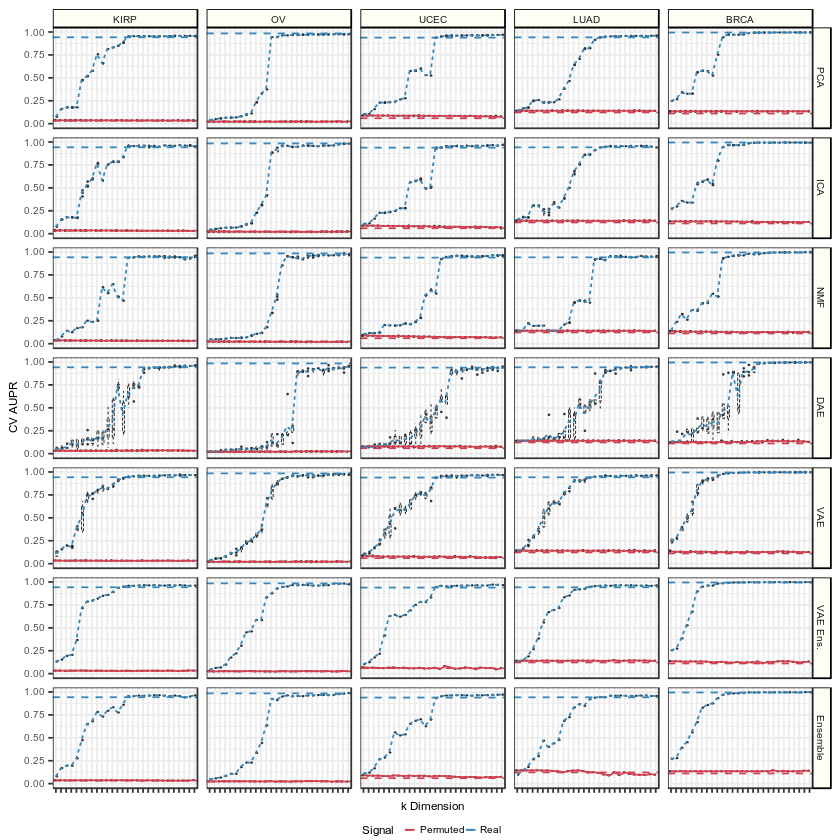

In [14]:
focus_cancertype_df <- full_cancertype_df %>%
    dplyr::filter(gene_or_cancertype %in% focus_cancertypes) %>%
    dplyr::mutate(gene_or_cancertype =
                  factor(gene_or_cancertype,
                         levels = focus_cancertypes))

focus_cancertype_ensemble_df <- full_cancertype_ensemble_df %>%
    dplyr::filter(gene_or_cancertype %in% focus_cancertypes) %>%
    dplyr::mutate(gene_or_cancertype =
                  factor(gene_or_cancertype,
                         levels = focus_cancertypes))

plot_ready_cancertype_df <- dplyr::bind_rows(
    focus_cancertype_df,
    focus_cancertype_ensemble_df
)

# Abbreviate and reorder factors for plotting
plot_ready_cancertype_df$algorithm <- plot_ready_cancertype_df$algorithm %>%
      dplyr::recode_factor("Model Ensemble" = "Ensemble",
                           "VAE Ensemble" = "VAE Ens.")

plot_ready_cancertype_df$algorithm <- factor(plot_ready_cancertype_df$algorithm,
                                             levels = plot_algorithm_refactor)


panel_a_gg <- plot_mutation_figure(df = plot_ready_cancertype_df,
                                   auroc_or_aupr = "aupr")
panel_a_gg <- panel_a_gg +
    classifier_base_theme +
    ylab("CV AUPR") +
    guides(color = guide_legend(keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

panel_a_gg

#### 2.2.2 Panel B - Select mutations AUC across dimensions and algorithms

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

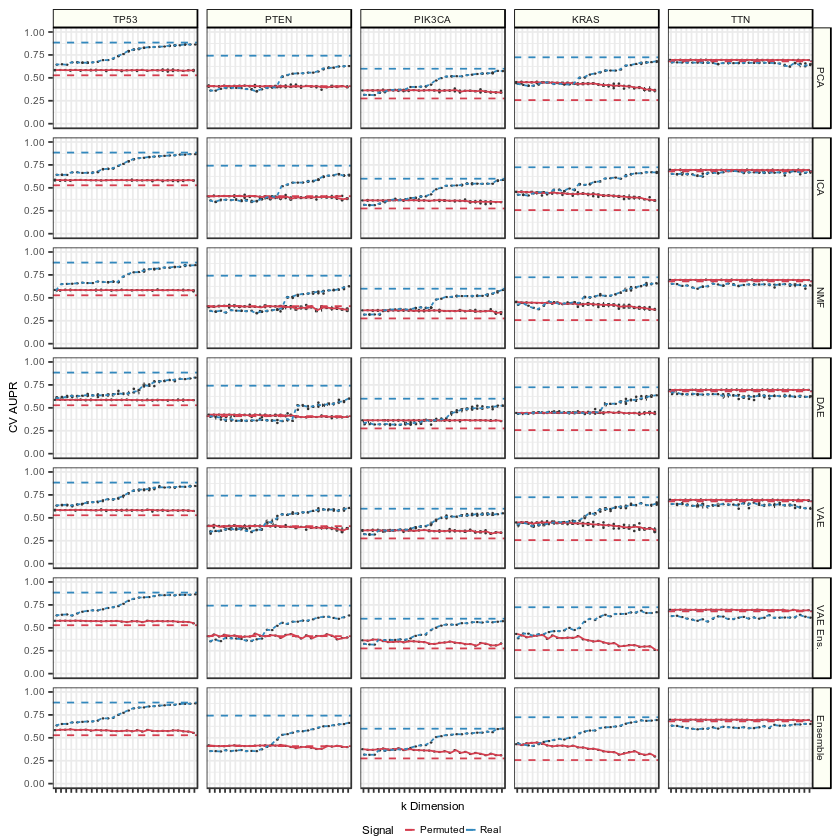

In [15]:
focus_mut_df <- full_mutation_df %>%
  dplyr::filter(gene_or_cancertype %in% focus_genes) %>%
  dplyr::mutate(gene_or_cancertype =
                  factor(gene_or_cancertype,
                         levels = focus_genes))

plot_ready_mut_df <- dplyr::bind_rows(focus_mut_df,
                                      full_mutation_ensemble_df)

# Abbreviate and reorder factors for plotting
plot_ready_mut_df$algorithm <- plot_ready_mut_df$algorithm %>%
      dplyr::recode_factor("Model Ensemble" = "Ensemble",
                           "VAE Ensemble" = "VAE Ens.")

plot_ready_mut_df$algorithm <- factor(plot_ready_mut_df$algorithm,
                                      levels = plot_algorithm_refactor)

panel_b_gg <- plot_mutation_figure(df = plot_ready_mut_df,
                                   auroc_or_aupr = "aupr")

panel_b_gg <- panel_b_gg +
    classifier_base_theme +
    ylab("CV AUPR") +
    guides(color = guide_legend(keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

panel_b_gg

#### 2.2.3 Panel C - Summary of All Cancer-Type Delta AUC with increasing K

In [16]:
cancertype_delta_auc_df <- process_delta_auc(focus_cancertype_df,
                                             auroc_or_aupr = "aupr",
                                             seed = "165158")

cancertype_delta_auc_ensemble_df <- process_delta_auc(focus_cancertype_ensemble_df,
                                                      auroc_or_aupr = "aupr",
                                                      seed = "ensemble")

cancertype_delta_auc_ensemble_all_features_df <-
    process_delta_auc(full_cancertype_all_ensemble_df,
                      auroc_or_aupr = "aupr",
                      seed = "ensemble_all_features")

line_plot_ready_cancertype_ensemble_df <- dplyr::bind_rows(
    cancertype_delta_auc_df,
    cancertype_delta_auc_ensemble_df
)

# Correct factor coercion error
line_plot_ready_cancertype_ensemble_df$algorithm <-
    factor(line_plot_ready_cancertype_ensemble_df$algorithm,
           levels = algorithm_refactor)

head(line_plot_ready_cancertype_ensemble_df)

Warning message:
“Unknown or uninitialised column: 'grouping_'.”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

auroc,aupr,gene_or_cancertype,signal,z_dim,seed,algorithm,data_type,grouping_,auroc_raw,aupr_raw,avg_auc,delta_auc,auc_k_diff,mean_delta_auc,sd_delta_auc
0.81487,0.076275,KIRP,signal,2,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.0762738,0.0394550,0.0000000,0.03739416,0.04456377
0.91487,0.161830,KIRP,signal,3,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.1618300,0.1251360,0.0856810,0.06612220,0.05757369
0.92605,0.178180,KIRP,signal,4,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.1781900,0.1414790,0.0163430,0.09751524,0.07492485
0.92615,0.177620,KIRP,signal,5,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.1776220,0.1406820,-0.0007970,0.12485908,0.05501051
0.92602,0.177430,KIRP,signal,6,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.1774300,0.1407192,0.0000372,0.12667972,0.05446207
0.96134,0.474430,KIRP,signal,7,165158,PCA,cv,KIRPsignal PCA,0.99262,0.94223,0.4746880,0.4380608,0.2973416,0.22904784,0.18808981


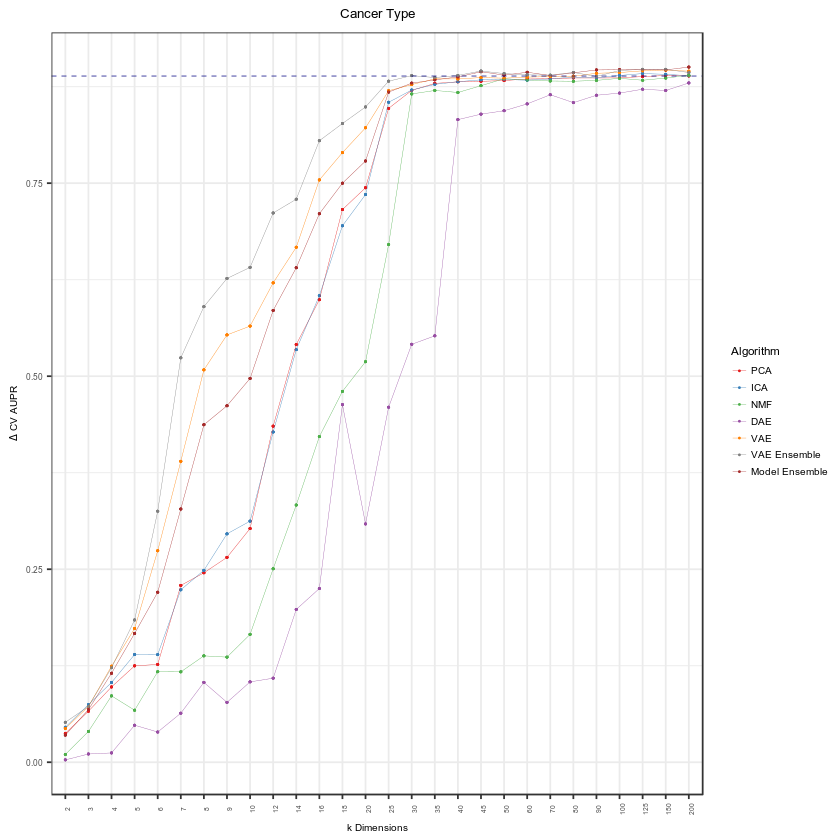

In [17]:
panel_c_gg <- plot_delta_auc_simple(plot_df = line_plot_ready_cancertype_ensemble_df,
                                    auroc_or_aupr = "aupr",
                                    plot_ensemble = TRUE,
                                    plot_all_features = TRUE,
                                    all_feature_df = cancertype_delta_auc_ensemble_all_features_df,
                                    plot_title = "Cancer Type")

panel_c_gg

#### 2.2.4 Panel D - Summary of All Mutation Delta AUROC with increasing K

In [18]:
mutation_delta_auroc_df <- process_delta_auc(focus_mut_df,
                                             auroc_or_aupr = "aupr",
                                             seed = "165158")

mutation_delta_auroc_ensemble_df <- process_delta_auc(full_mutation_ensemble_df,
                                                      auroc_or_aupr = "aupr",
                                                      seed = "ensemble")

mutation_delta_auc_ensemble_all_features_df <-
    process_delta_auc(full_mutation_all_ensemble_df,
                      auroc_or_aupr = "aupr",
                      seed = "ensemble_all_features")

line_plot_ready_mutation_ensemble_df <- dplyr::bind_rows(
    mutation_delta_auroc_df,
    mutation_delta_auroc_ensemble_df
)

# Correct factor coercion error
line_plot_ready_mutation_ensemble_df$algorithm <-
    factor(line_plot_ready_mutation_ensemble_df$algorithm,
           levels = algorithm_refactor)

head(line_plot_ready_mutation_ensemble_df)

Warning message:
“Unknown or uninitialised column: 'grouping_'.”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

auroc,aupr,gene_or_cancertype,signal,z_dim,seed,algorithm,data_type,grouping_,auroc_raw,aupr_raw,avg_auc,delta_auc,auc_k_diff,mean_delta_auc,sd_delta_auc
0.68487,0.64385,TP53,signal,2,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.643850,0.058476,0.000000,-0.0163364,0.04380091
0.70778,0.64807,TP53,signal,3,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.648070,0.062906,0.004430,-0.0184856,0.04671708
0.70687,0.64340,TP53,signal,4,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.643400,0.059602,-0.003304,-0.0165396,0.04371686
0.72940,0.66853,TP53,signal,5,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.668542,0.084266,0.024664,-0.0060572,0.05077903
0.72972,0.66930,TP53,signal,6,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.669304,0.084326,0.000060,-0.0016876,0.04828474
0.72963,0.66553,TP53,signal,7,165158,PCA,cv,TP53signal PCA,0.91836,0.88467,0.665532,0.081894,-0.002432,0.0076228,0.04410069


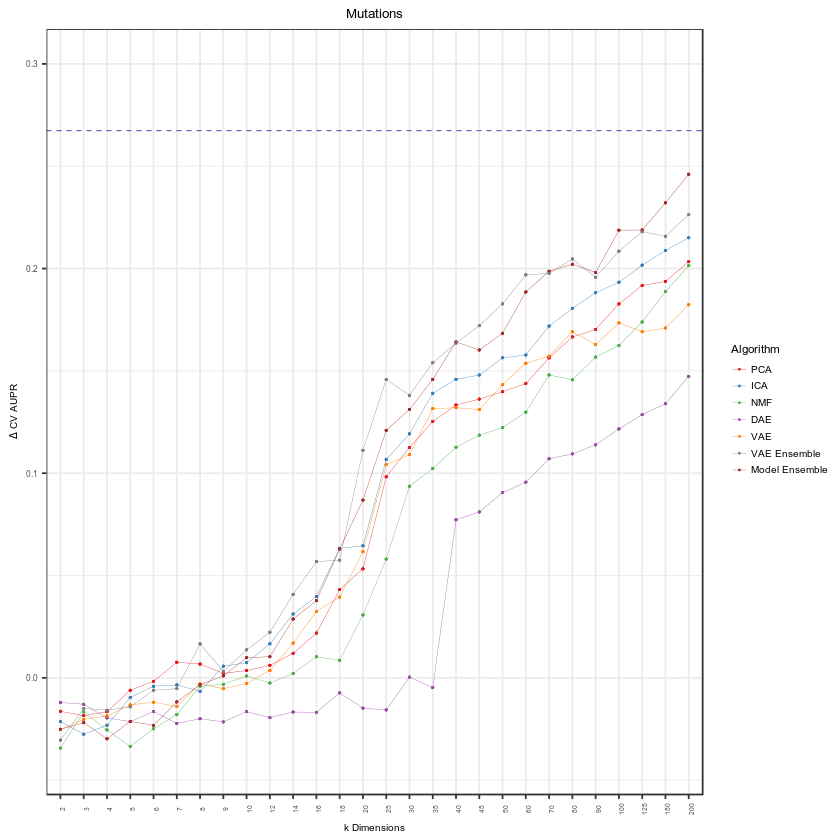

In [19]:
panel_d_gg <- plot_delta_auc_simple(plot_df = line_plot_ready_mutation_ensemble_df,
                                    auroc_or_aupr = "aupr",
                                    plot_ensemble = TRUE,
                                    plot_all_features = TRUE,
                                    all_feature_df = mutation_delta_auc_ensemble_all_features_df,
                                    plot_title = "Mutations")

panel_d_gg <- panel_d_gg + ylim(c(-0.04, 0.3))
panel_d_gg

#### 2.2.5 Panel E - Sparsity of Select Models for Mutation Prediction

In [20]:
# Load Results
full_coef_results <- load_results(results_path = mut_path,
                                  file_string = "coefficients")

full_coef_ensemble_results_df <- load_results(results_path = mut_ensemble_path,
                                              file_string = "coefficients",
                                              process_ensemble = TRUE,
                                              process_output = FALSE)

full_coef_ensemble_all_features_results_df <-
    load_results(results_path = mutation_all_ensemble_path,
                 file_string = "coefficients",
                 process_all_features = TRUE,
                 process_output = FALSE)

In [21]:
# Process full coefficient results
coef_df <- full_coef_results[["metrics"]]
raw_coef_df <- full_coef_results[["raw_metrics"]]

In [22]:
# Process ensemble results
full_coef_ensemble_results_df <- dplyr::bind_rows(full_coef_ensemble_results_df)

# Adjust factor
full_coef_ensemble_results_df$algorithm <- full_coef_ensemble_results_df$algorithm %>%
      dplyr::recode_factor("all_ensemble" = "Model Ensemble",
                           "vae_ensemble" = "VAE Ensemble")

In [23]:
# Process sparsity
sparsity_metric_df <- process_sparsity(coef_df = coef_df,
                                       mut_df = full_mutation_df,
                                       focus_genes = focus_genes)

raw_sparsity_metric_df <- process_sparsity(coef_df = raw_coef_df,
                                           mut_df = full_mutation_info$raw_metrics,
                                           focus_genes = focus_genes)

ensemble_sparsity_metric_df <- process_sparsity(coef_df = full_coef_ensemble_results_df,
                                                mut_df = full_mutation_ensemble_df,
                                                focus_genes = focus_genes,
                                                process_ensemble = TRUE)

ensemble_all_feature_sparsity_metric_df <-
    process_sparsity(coef_df = full_coef_ensemble_all_features_results_df,
                     mut_df = full_mutation_all_ensemble_df,
                     focus_genes = focus_genes,
                     process_all_features = TRUE)

Warning message:
“Column `gene`/`gene_or_cancertype` joining character vector and factor, coercing into character vector”Warning message:
“Column `gene`/`gene_or_cancertype` joining character vector and factor, coercing into character vector”

In [24]:
# Setup Plotting logic
scale_colors <- c(
    "PCA" = "#e41a1c",
    "ICA" = "#377eb8",
    "NMF" = "#4daf4a",
    "DAE" = "#984ea3",
    "VAE" = "#ff7f00",
    "Model Ensemble" = "brown",
    "VAE Ensemble" = "grey50"
)

scale_labels <- c(
    "PCA" = "PCA",
    "ICA" = "ICA",
    "NMF" = "NMF",
    "DAE" = "DAE",
    "VAE" = "VAE",
    "Model Ensemble" = "Model Ensemble",
    "VAE Ensemble" = "VAE Ensemble"
)

plot_ready_sparsity_df <- dplyr::bind_rows(
    sparsity_metric_df,
    ensemble_sparsity_metric_df
)

# Correct factor coercion error
plot_ready_sparsity_df$algorithm <-
    factor(plot_ready_sparsity_df$algorithm,
           levels = algorithm_refactor)

head(plot_ready_sparsity_df)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

gene,signal,z_dim,seed,algorithm,weight,num_features,percent_zero,auroc,aupr,data_type,grouping_,auroc_raw,aupr_raw,z_dim_shape
KRAS,shuffled,2,165158,PCA,8,13,0.6153846,0.71174,0.45665,cv,KRASshuffled,0.52104,0.25726,z < 20
KRAS,shuffled,2,165158,ICA,8,13,0.6153846,0.71139,0.45533,cv,KRASshuffled,0.52104,0.25726,z < 20
KRAS,shuffled,2,165158,NMF,7,13,0.5384615,0.71003,0.46134,cv,KRASshuffled,0.52104,0.25726,z < 20
KRAS,shuffled,2,165158,DAE,8,13,0.6153846,0.71823,0.44450,cv,KRASshuffled,0.52104,0.25726,z < 20
KRAS,shuffled,2,165158,VAE,8,13,0.6153846,0.71353,0.45329,cv,KRASshuffled,0.52104,0.25726,z < 20
KRAS,shuffled,2,451283,PCA,8,13,0.6153846,0.71622,0.45347,cv,KRASshuffled,0.52104,0.25726,z < 20


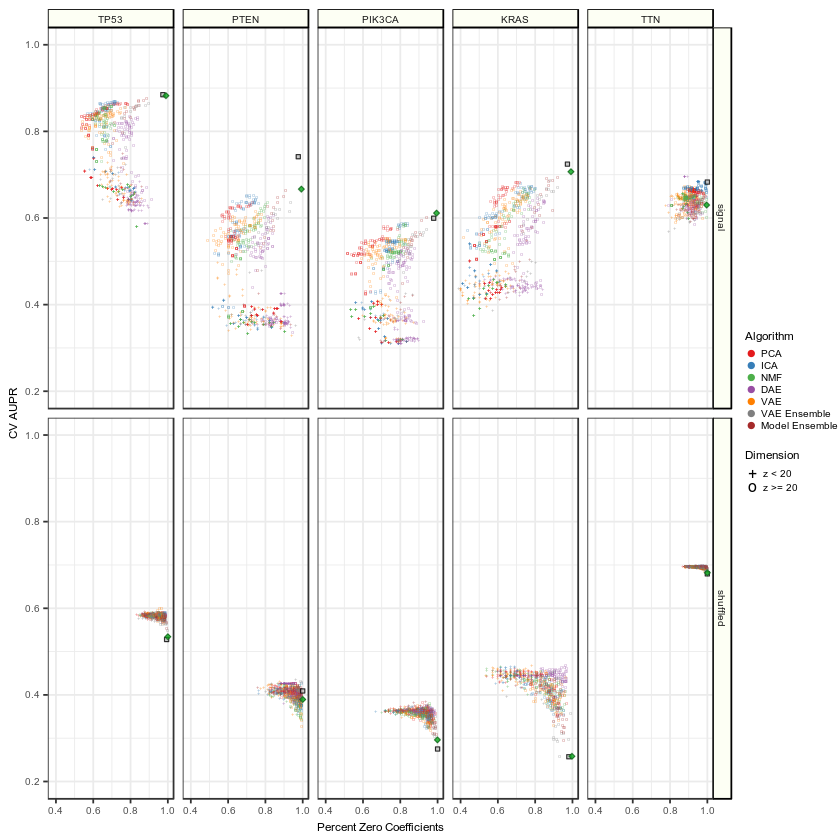

In [25]:
panel_e_gg <- ggplot(plot_ready_sparsity_df,
                     aes(x = percent_zero,
                         y = aupr)) +
  geom_point(aes(color = algorithm,
                 shape = z_dim_shape),
             size = 0.9,
             alpha = 0.5) +
  geom_point(data = raw_sparsity_metric_df,
             aes(x = percent_zero,
                 y = aupr),
             alpha = 0.8,
             size = 1,
             color = "black",
             fill = "grey",
             pch = 22) +
  geom_point(data = ensemble_all_feature_sparsity_metric_df,
             aes(x = percent_zero,
                 y = aupr),
             alpha = 0.8,
             size = 1,
             color = "#176620",
             fill = "#05a818",
             pch = 23) +
  scale_color_manual(name = "Algorithm",
                     values = scale_colors,
                     labels = scale_labels) +
  scale_shape_manual(values = c("+", "o")) +
  ylim(c(0.2, 1)) +
  ylab("CV AUPR") +
  xlab("Percent Zero Coefficients") + 
  facet_grid(signal ~ gene) +
  theme_bw() +
  theme(strip.background = element_rect(colour = "black", fill = "#fdfff4"),
        strip.text = element_text(size = 7),
        strip.text.x = element_text(size = 6,
                                      margin = margin(
                                          t = 4,
                                          b = 3,
                                          l = 0,
                                          r = 0)
                                     ),
          strip.text.y = element_text(size = 6,
                                      margin = margin(
                                          t = 0,
                                          b = 0,
                                          l = 3,
                                          r = 4)
                                     ),
        axis.title = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        legend.position = "right",
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
        legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3)) +
  guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 1.4,
                                                  alpha = 1)),
         shape = guide_legend(order = 2,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              title = "Dimension",
                              override.aes = list(size = 3,
                                                  alpha = 1)))

panel_e_gg

In [26]:
# Create a dummy plot to use in cowplot legend for sparsity figure
custom_data <- as.data.frame(cbind(c(1, 2), c(3, 4), c("A", "B")))
colnames(custom_data) <- c('one', 'two', 'three')
custom_data

one,two,three
1,3,A
2,4,B


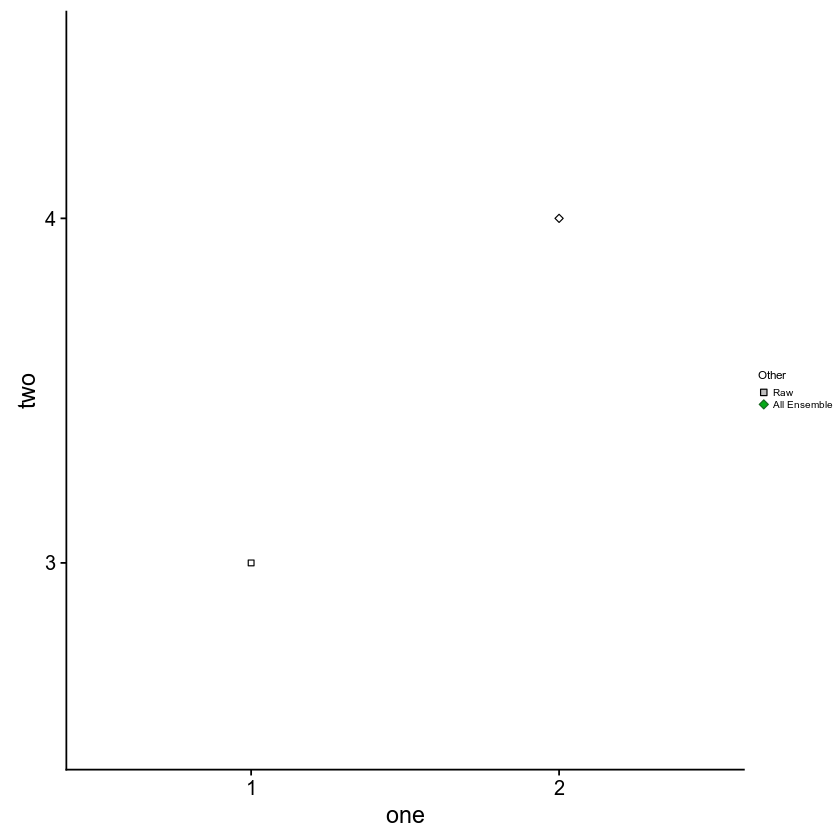

In [27]:
custom_gg <- ggplot(custom_data,
                    aes(x = one, y = two)) +
    geom_point(aes(shape = three)) +
    scale_shape_manual(name = "Other",
                       values = c(22, 23),
                       labels = c("Raw",
                                  "All Ensemble")) +
    theme(legend.position = "right",
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3)) +
  guides(shape = guide_legend(order = 2,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              title = "Other",
                              override.aes = list(fill = c("grey",
                                                             "#05a818"),
                                                  color = c("black",
                                                            "#176620"),
                                                  size = 1.7,
                                                  alpha = 1)))
custom_gg

#### 2.2.6 Determining which features have highest importance in classification in all feature ensemble

**NOTE** - This figure is no longer included in the plot.
It is now redundant with existing panels

In [28]:
# Find Model with High Sparsity and High Performance
top_gene <- "TP53"

top_feature_search_df <- ensemble_all_feature_sparsity_metric_df %>%
  dplyr::filter(algorithm == 'all_feature_ensemble',
                gene == top_gene) %>% 
  dplyr::top_n(1, aupr)

outfile <- file.path("results", "top_model_ensemble_all_features_tp53_feature_for_followup.tsv")
readr::write_tsv(top_feature_search_df, outfile)

top_feature_search_df

gene,signal,z_dim,seed,algorithm,weight,num_features,percent_zero,auroc,aupr,data_type
TP53,signal,all,ensemble_all_features,all_feature_ensemble,30555,30872,0.9897318,0.91202,0.88231,cv


In [29]:
# This is an ensemble model, what feature is most explanatory in this model?
full_coef_ensemble_all_features_results_df$seed <- "ensemble_all_features"

top_tp53_features <- full_coef_ensemble_all_features_results_df %>%
    dplyr::filter(z_dim == top_feature_search_df$z_dim,
                  seed == top_feature_search_df$seed,
                  algorithm == 'all_feature_ensemble',
                  gene == top_gene,
                  signal == 'signal') %>%
    dplyr::arrange(weight)

top_tp53_features$ranked <- 1:nrow(top_tp53_features)

In [30]:
# Process plotting labels
algorithm_assign <- c()
algorithm_label <- c()
all_ks <- c()
for (feature in strsplit(top_tp53_features$feature, "_")) {
    feature_id_unlist <- unlist(feature)
    algorithm <- feature_id_unlist[1]
    feature <- feature_id_unlist[2]
    k <- feature_id_unlist[4]
    algorithm_label <- c(algorithm_label, algorithm)
    algorithm_assign <- c(algorithm_assign,
                        paste0(toupper(algorithm),
                               "_",
                               k))
    all_ks <- c(all_ks, k)
}

top_tp53_features$algorithm_label <- algorithm_label
top_tp53_features$algorithm_assign <- algorithm_assign
top_tp53_features$k <- all_ks
top_tp53_features$pos_label <- "Positive"
top_tp53_features[top_tp53_features$weight < 0, "pos_label"] <- 'Negative'

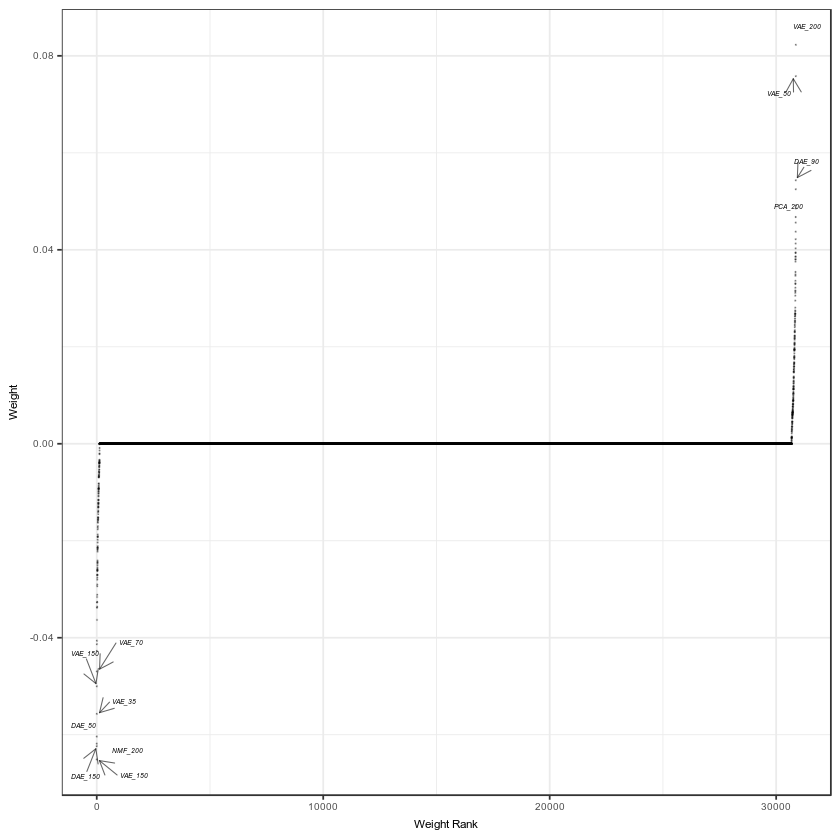

In [31]:
weight_rank_gg <- ggplot(top_tp53_features,
                     aes(x = ranked, y = weight)) +
  geom_point(alpha = 0.3,
             size = 0.02) +
  xlab("Weight Rank") +
  ylab("Weight") +
  geom_text_repel(data = subset(top_tp53_features,
                                (weight > 0.05 | weight < -0.045)),
                  arrow = arrow(length = unit(0.02, 'npc')),
                  segment.size = 0.3,
                  segment.alpha = 0.6,
                  box.padding = 0.4,
                  point.padding = 0.22,
                  size = 1.4,
                  fontface = 'italic',
                  aes(x = ranked,
                      y = weight,
                      label = algorithm_assign)) +
  theme_bw() +
  theme(axis.title = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6))

weight_rank_gg

#### 2.2.7 Panel F - Receiver Operating Characteristic Curve of All Feature Ensemble Model Predicting TP53

In [32]:
metric_col_type <- readr::cols(
    .default = readr::col_double(),
    predictor = readr::col_character(),
    signal = readr::col_character(),
    z_dim = readr::col_character(),
    seed = readr::col_character(),
    algorithm = readr::col_character(),
    data_type = readr::col_character()
)

In [33]:
# Find metrics for the specific model
top_model_path <- file.path("results",
                            "mutation_ensemble_all",
                            top_gene)

auc_file <- file.path(top_model_path,
                      paste0(top_gene,
                             "_ensemble_all_features_auc_threshold_metrics.tsv.gz"))

roc_df <- readr::read_tsv(auc_file,
                          col_types = metric_col_type) %>%
  dplyr::filter(z_dim == top_feature_search_df$z_dim,
                seed == top_feature_search_df$seed,
                algorithm == 'all_feature_ensemble')

aupr_file <- file.path(top_model_path,
                       paste0(top_gene,
                              "_ensemble_all_features_aupr_threshold_metrics.tsv.gz"))

pr_df <- readr::read_tsv(aupr_file,
                         col_types = metric_col_type) %>%
  dplyr::filter(z_dim == top_feature_search_df$z_dim,
                seed == top_feature_search_df$seed,
                algorithm == 'all_feature_ensemble')

In [34]:
# Load Raw metrics
raw_model_path <- file.path("results", "mutation", top_gene)

auc_raw_file <- file.path(raw_model_path,
                          paste0(top_gene, "_raw_auc_threshold_metrics.tsv.gz"))
roc_raw_df <- readr::read_tsv(auc_raw_file, col_types = metric_col_type) 

aupr_raw_file <- file.path(raw_model_path,
                           paste0(top_gene, "_raw_aupr_threshold_metrics.tsv.gz"))
pr_raw_df <- readr::read_tsv(aupr_raw_file, col_types = metric_col_type)

# Process auc data
full_roc_df <- dplyr::bind_rows(roc_df, roc_raw_df)
full_roc_df$model_groups <- paste(full_roc_df$algorithm, full_roc_df$data_type)

full_pr_df <- dplyr::bind_rows(pr_df, pr_raw_df)
full_pr_df$model_groups <- paste(full_pr_df$algorithm, full_pr_df$data_type)

In [35]:
# Setup plotting variables
curve_colors <- c("#1b9e77",
                  "#d95f02",
                  "#7570b3",
                  "#737373",
                  "#bdbdbd",
                  "#d9d9d9")

curve_labels <- c("all_feature_ensemble cv" = "Ensemble CV",
                  "all_feature_ensemble test" = "Ensemble Test",
                  "all_feature_ensemble train" = "Ensemble Train",
                  "raw cv" = "Raw CV",
                  "raw test" = "Raw Test",
                  "raw train" = "Raw Train")

curve_base_theme <-
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3))

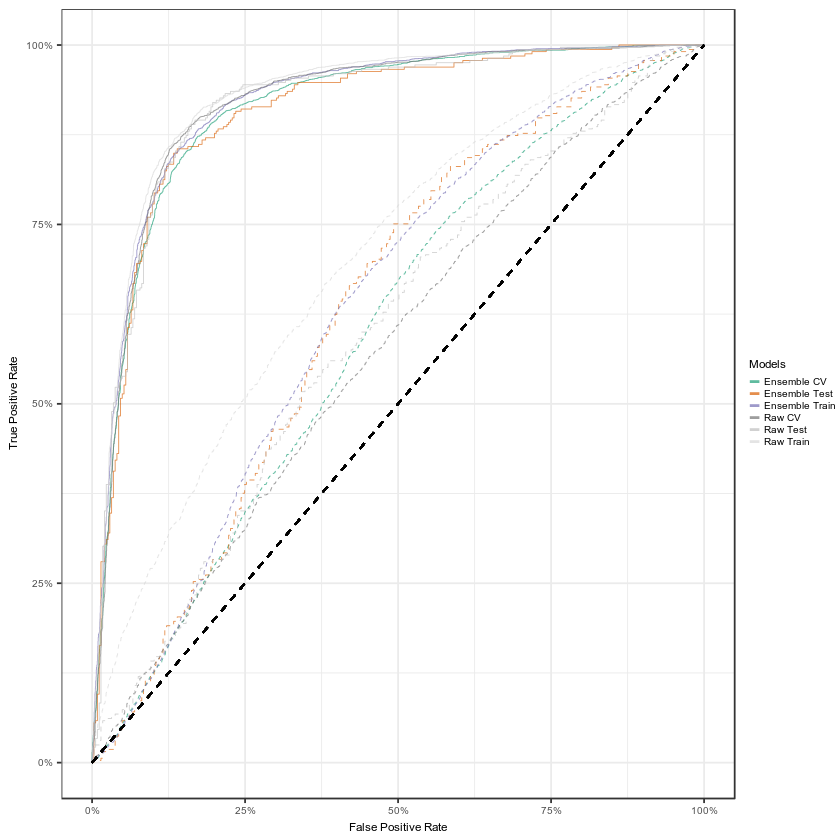

In [36]:
panel_f_gg <- ggplot(full_roc_df,
                     aes(x = fpr,
                         y = tpr,
                         color = model_groups)) +
    geom_step(aes(linetype = signal),
              alpha = 0.7,
              size = 0.25) +
    geom_segment(aes(x = 0,
                     y = 0,
                     xend = 1,
                     yend = 1),
               linetype = "dashed",
               color = "black") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_continuous(labels = scales::percent) +
    scale_color_manual(name = "Models",
                     values = curve_colors,
                     labels = curve_labels) +
    scale_linetype_manual(name = "Data",
                        values = c("dashed",
                                   "solid"),
                     labels = c("signal" = "Signal",
                                "shuffled" = "Shuffled")) +
    xlab("False Positive Rate") +
    ylab("True Positive Rate") +
    theme_bw() +
    curve_base_theme +
    guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 0.8)),
         linetype = FALSE)

panel_f_gg

#### 2.2.8 Panel G - Precision Recall Curve of All Feature Ensemble Model Predicting TP53

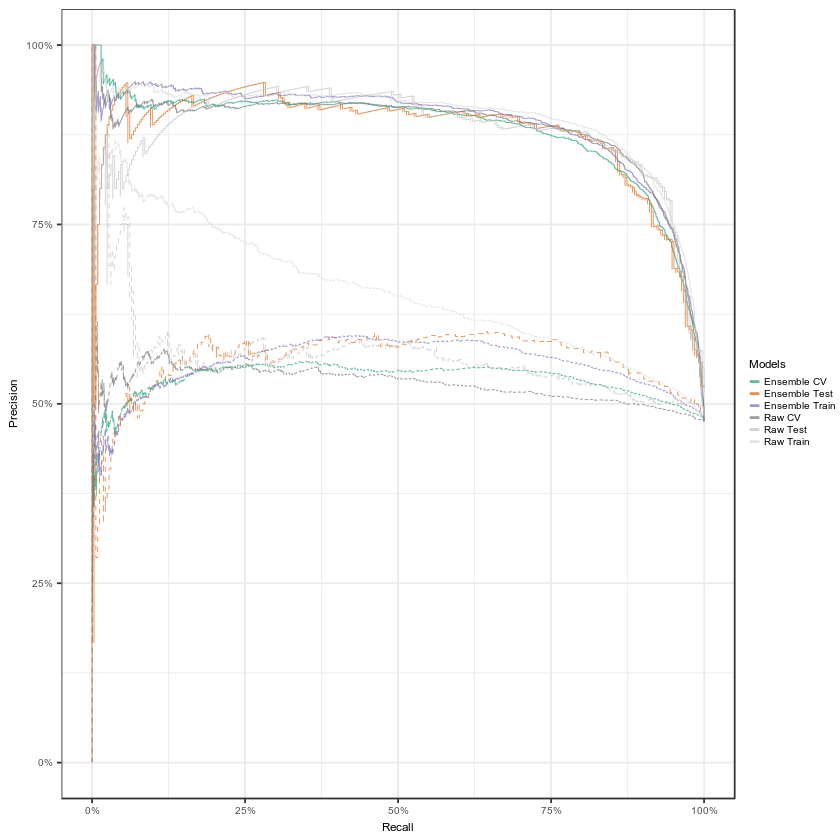

In [37]:
panel_g_gg <- ggplot(full_pr_df,
                     aes(x = recall,
                         y = precision,
                         color = model_groups)) +
  geom_step(aes(linetype = signal),
            alpha = 0.7,
            size = 0.25) +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(labels = scales::percent) +
  scale_color_manual(name = "Models",
                     values = curve_colors,
                     labels = curve_labels) +
  scale_linetype_manual(name = "Data",
                        values = c("dashed",
                                   "solid"),
                        labels = c("signal" = "Signal",
                                   "shuffled" = "Shuffled")) +
  xlab("Recall") +
  ylab("Precision") +
  theme_bw() +
  curve_base_theme +
  guides(color = guide_legend(order = 1,
                              keywidth = 0.1,
                              keyheight = 0.1,
                              default.unit = "inch",
                              override.aes = list(size = 0.8)),
         linetype = FALSE)

panel_g_gg

#### 2.2.9 Panel H - Contribution of Algorithms to Model

In [38]:
algorithm_contribution_df <- top_tp53_features %>%
    dplyr::group_by(algorithm_label, pos_label, k) %>%
    dplyr::summarize(algorithm_contribution = sum(abs)) %>%
    dplyr::arrange(desc(algorithm_contribution)) %>%
    dplyr::filter(algorithm_contribution != 0)

algorithm_contribution_df$algorithm_label <-
    factor(algorithm_contribution_df$algorithm_label,
           levels = c("pca", "ica", "nmf", "dae", "vae", "log10"))

algorithm_contribution_df$pos_label <-
    factor(algorithm_contribution_df$pos_label,
           levels = c("Negative", "Positive"))

algorithm_contribution_df[algorithm_contribution_df$pos_label != "Positive", "algorithm_contribution"] <-
    algorithm_contribution_df[algorithm_contribution_df$pos_label != "Positive", "algorithm_contribution"] * -1

algorithm_contribution_df$k <-
    factor(algorithm_contribution_df$k,
           levels = sort(as.numeric(paste(unique(algorithm_contribution_df$k)))))

head(algorithm_contribution_df)

algorithm_label,pos_label,k,algorithm_contribution
vae,Positive,200,0.3186785
vae,Negative,150,-0.3026448
ica,Positive,150,0.2342324
nmf,Positive,200,0.1681075
nmf,Positive,125,0.1671863
vae,Negative,200,-0.1593758


In [39]:
# Setup Plotting logic
bar_colors <- c(
    "pca" = "#e41a1c",
    "ica" = "#377eb8",
    "nmf" = "#4daf4a",
    "dae" = "#984ea3",
    "vae" = "#ff7f00",
    "log10" = "grey75"
)

bar_labels <- c(
    "pca" = "PCA",
    "ica" = "ICA",
    "nmf" = "NMF",
    "dae" = "DAE",
    "vae" = "VAE",
    "log10" = "log10"
)

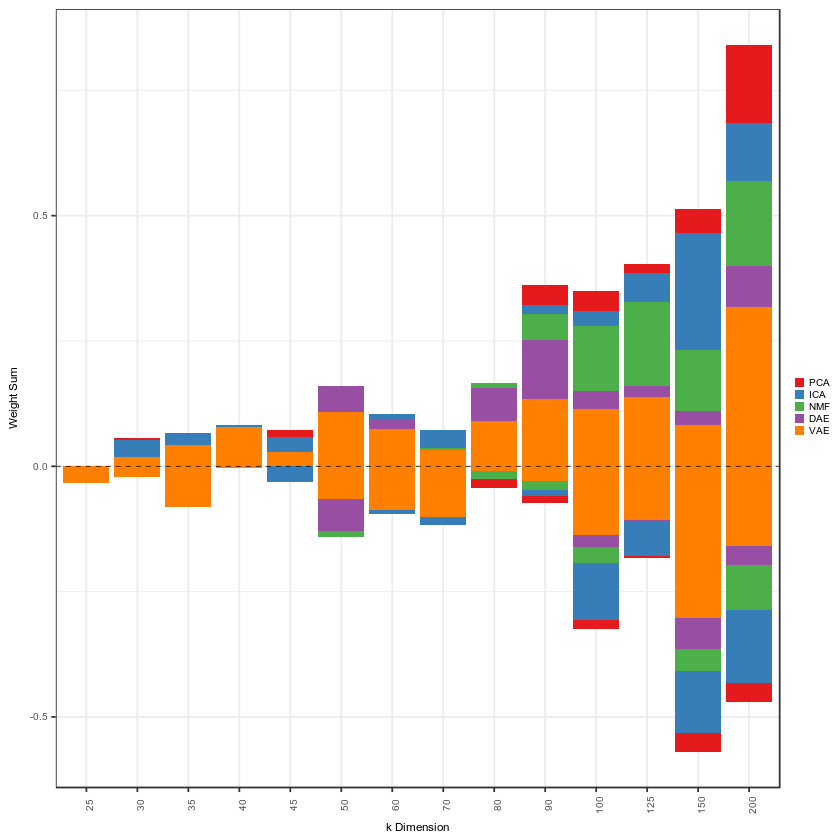

In [40]:
panel_h_gg <- ggplot(algorithm_contribution_df,
                     aes(x = k,
                         y = algorithm_contribution,
                         fill = algorithm_label)) +
    geom_bar(stat = "identity",
             position = "stack") +
    geom_hline(yintercept = 0,
               lwd = 0.2,
               color = "black", 
               linetype = "dashed") +
    scale_fill_manual(name = "",
                      labels = bar_labels,
                      values = bar_colors) +
    ylab("Weight Sum") +
    xlab("k Dimension") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6, angle = 90),
          axis.text.y = element_text(size = 6),
          legend.position = "right",
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 6),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3)) +
    guides(fill = guide_legend(order = 1,
                               keywidth = 0.1,
                               keyheight = 0.1,
                               default.unit = "inch",
                               override.aes = list(size = 0.8)))

panel_h_gg

### 2.3 Compile Full Main Figure

In [41]:
a_and_b_legend_gg <- cowplot::get_legend(panel_a_gg)

a_and_b_gg <- cowplot::plot_grid(
    panel_a_gg + theme(legend.position = "none"),
    panel_b_gg + theme(legend.position = "none"),
    rel_widths = c(1, 1),
    labels = c("a", "b"),
    ncol = 2
)

a_and_b_gg <- cowplot::plot_grid(
    a_and_b_gg,
    a_and_b_legend_gg,
    rel_heights = c(1, 0.04),
    nrow = 2
)

c_and_d_gg <- cowplot::plot_grid(
    panel_c_gg +
        theme(legend.position = "none",
              plot.title = element_text(margin = margin(b = 1,
                                                        unit = "pt")),
              plot.margin = unit(c(5.5, 5.5, 0, 5.5),
                                 "pt")) +
        xlab(""),
    panel_d_gg + theme(legend.position = "none",
                       plot.title = element_text(margin = margin(b = 1,
                                                                 unit = "pt")),
                       plot.margin = unit(c(3, 5.5, 5.5, 5.5),
                                          "pt")),
    nrow = 2,
    labels = c("c", "d")
)

panel_e_legend <- cowplot::get_legend(panel_e_gg +
                                     theme(legend.justification = c(0.54, 0.6)))
custom_legend <- cowplot::get_legend(custom_gg +
                                     theme(legend.justification = c(0.30, 0.55)))

panel_e_full_legend <- (
    cowplot::plot_grid(
        cowplot::ggdraw(),
        panel_e_legend,
        custom_legend,
        ncol = 1,
        nrow = 3,
        rel_heights = c(0.5, 1, 1)
    )
)

panel_e_with_legend_gg = (
    cowplot::plot_grid(
        panel_e_gg + theme(legend.position = "none"),
        panel_e_full_legend,
        rel_widths = c(1, 0.2),
        ncol = 2
    )
)

c_d_and_e_gg <- cowplot::plot_grid(
    c_and_d_gg,
    panel_e_with_legend_gg,
    rel_widths = c(0.4, 1),
    labels = c("", "e"),
    ncol = 2
)

f_and_g_legend_gg <- cowplot::get_legend(panel_f_gg +
                                         theme(legend.justification = c(0.5, 0.7)))

f_and_g_gg <- cowplot::plot_grid(
    panel_f_gg + theme(legend.position = "none"),
    panel_g_gg + theme(legend.position = "none"),
    rel_widths = c(1, 1),
    labels = c("f", "g"),
    ncol = 2,
    nrow = 1
)

f_and_g_gg <- cowplot::plot_grid(
    f_and_g_gg,
    f_and_g_legend_gg,
    rel_widths = c(1, 0.2),
    ncol = 2
)

f_g_and_h_gg <- cowplot::plot_grid(
    f_and_g_gg,
    panel_h_gg + theme(legend.position = "right"),
    rel_widths = c(1, 0.6),
    labels = c("", "h"),
    ncol = 2
)

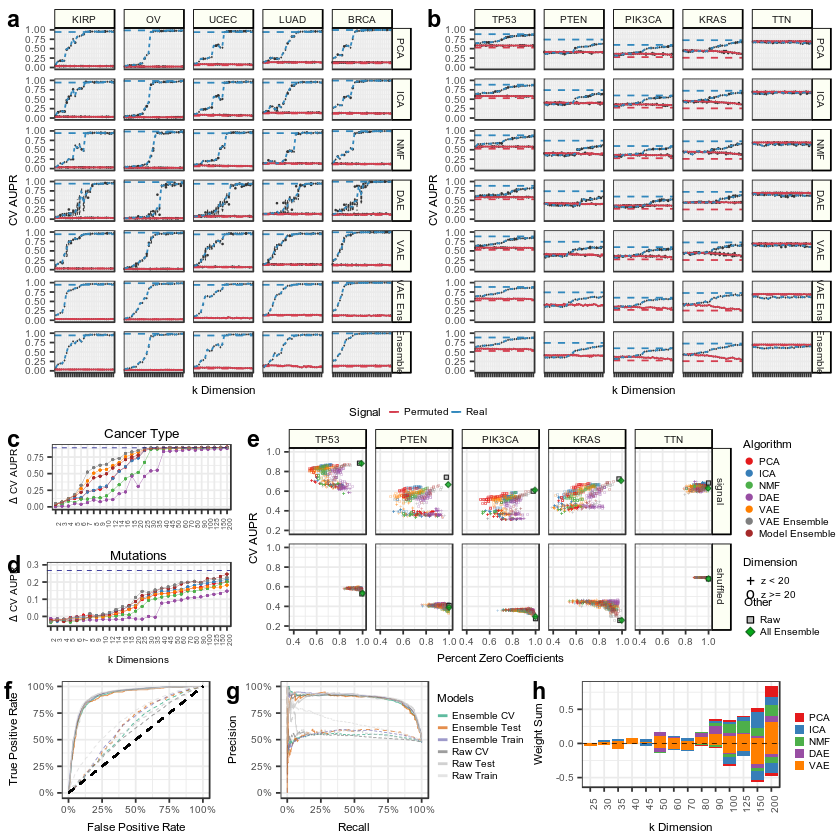

In [42]:
full_gg <- cowplot::plot_grid(
    a_and_b_gg,
    c_d_and_e_gg,
    f_g_and_h_gg,
    nrow = 3,
    labels = c("", "", ""),
    rel_heights = c(1.5, 0.9, 0.6)
)

full_gg

In [43]:
for(extension in c('.png', '.pdf')) {
    gg_file <- paste0("tcga_biobombe_main_figure", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = full_gg,
                       dpi = 300,
                       base_height = 200,
                       base_width = 170,
                       units = "mm")
}